In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, to_date, lit, count, sum as spark_sum, round, month, year
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

In [ ]:
spark = SparkSession.builder \
    .appName("RetailDataCleaning") \
    .master("local[*]") \
    .getOrCreate()

In [ ]:
# очистка даних

In [ ]:
path = kagglehub.dataset_download('aslanahmedov/walmart-sales-forecast')
features_df = spark.read.csv(f"{path}/features.csv", header=True, inferSchema=True)
stores_df = spark.read.csv(f"{path}/stores.csv", header=True, inferSchema=True)
train_df = spark.read.csv(f"{path}/train.csv", header=True, inferSchema=True)

In [ ]:
features_df = features_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
features_df = features_df.drop("IsHoliday")
features_df.show(5) # перевірка

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|    1|2010-02-05|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|
|    1|2010-02-12|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|
|    1|2010-02-19|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|
|    1|2010-02-26|      46.63|     2.561|       NA|       NA|       NA|       NA|       NA|211.3196429|       8.106|
|    1|2010-03-05|       46.5|     2.625|       NA|       NA|       NA|       NA|       NA|211.3501429|       8.106|
+-----+----------+-----------+----------+---------+---------+---

In [ ]:
for markdown in ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]:
    features_df = features_df.withColumn(markdown, when(col(markdown) == "NA", None).otherwise(col(markdown)))

for markdown in ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]:
    features_df = features_df.withColumn(markdown, when(col(markdown).isNull(), 0).otherwise(col(markdown)))

In [ ]:
for column in ["CPI", "Unemployment"]:
    mean_value = features_df.select(mean(col(column))).collect()[0][0]
    features_df = features_df.withColumn(column, when(col(column).isNull(), mean_value).otherwise(col(column)))

In [ ]:
features_df.show(5) # перевірка

+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|    1|2010-02-05|      42.31|     2.572|        0|        0|        0|        0|        0|211.0963582|       8.106|
|    1|2010-02-12|      38.51|     2.548|        0|        0|        0|        0|        0|211.2421698|       8.106|
|    1|2010-02-19|      39.93|     2.514|        0|        0|        0|        0|        0|211.2891429|       8.106|
|    1|2010-02-26|      46.63|     2.561|        0|        0|        0|        0|        0|211.3196429|       8.106|
|    1|2010-03-05|       46.5|     2.625|        0|        0|        0|        0|        0|211.3501429|       8.106|
+-----+----------+-----------+----------+---------+---------+---

In [ ]:
train_df = train_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
train_df = train_df.withColumn("IsHoliday", col("IsHoliday").cast("boolean"))
train_df.show(5)

+-----+----+----------+------------+---------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|    1|   1|2010-02-05|     24924.5|    false|
|    1|   1|2010-02-12|    46039.49|     true|
|    1|   1|2010-02-19|    41595.55|    false|
|    1|   1|2010-02-26|    19403.54|    false|
|    1|   1|2010-03-05|     21827.9|    false|
+-----+----+----------+------------+---------+
only showing top 5 rows



In [ ]:
combined_df = train_df.join(stores_df, on="Store", how="left")
df = combined_df.join(features_df, on=["Store", "Date"], how="left")
df.show(5)

+-----+----------+----+------------+---------+----+------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Type|  Size|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|
+-----+----------+----+------------+---------+----+------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+
|    1|2010-02-05|   1|     24924.5|    false|   A|151315|      42.31|     2.572|        0|        0|        0|        0|        0|211.0963582|       8.106|
|    1|2010-02-12|   1|    46039.49|     true|   A|151315|      38.51|     2.548|        0|        0|        0|        0|        0|211.2421698|       8.106|
|    1|2010-02-19|   1|    41595.55|    false|   A|151315|      39.93|     2.514|        0|        0|        0|        0|        0|211.2891429|       8.106|
|    1|2010-02-26|   1|    19403.54|    false|   A|151315|

In [ ]:
df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: string (nullable = true)
 |-- MarkDown2: string (nullable = true)
 |-- MarkDown3: string (nullable = true)
 |-- MarkDown4: string (nullable = true)
 |-- MarkDown5: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)



Розглянута кількість магазинів Walmart: 45

Кількість магазинів за типами (до перерахунку відсотків):
  Type  count
0    B     17
1    C      6
2    A     22

Розподіл магазинів за типами у відсотках:
  Type  count  percentage
0    B     17   37.777778
1    C      6   13.333333
2    A     22   48.888889


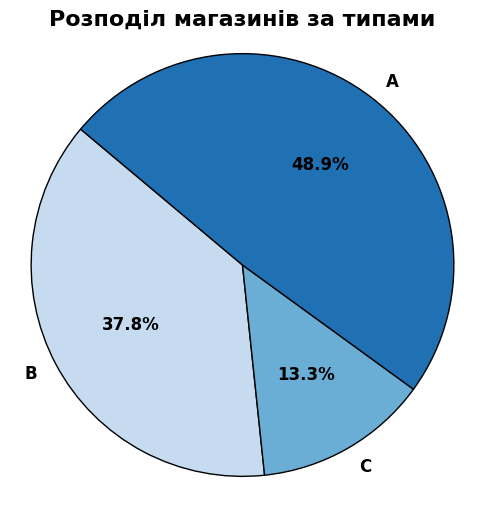


Висновок:
3. Після перерахунку відсотків, можна побачити, що більшість магазинів Walmart відносяться до типу A.
4. Кругова діаграма наочно показує розподіл магазинів за типами.


In [ ]:
store_counts = stores_df.groupBy("Type").count()
total_stores = stores_df.count()
store_percentages = store_counts.withColumn(
    "percentage",
    (col("count") * 100 / lit(total_stores))
)

store_percentages_pd = store_percentages.toPandas()

print("Розглянута кількість магазинів Walmart:", total_stores)
print("\nКількість магазинів за типами (до перерахунку відсотків):")
print(store_counts.toPandas())
print("\nРозподіл магазинів за типами у відсотках:")
print(store_percentages.toPandas())

colors = sns.color_palette("Blues", len(store_percentages_pd))
plt.figure(figsize=(6, 6))
plt.pie(
    store_percentages_pd["percentage"],
    labels=store_percentages_pd["Type"],
    autopct='%1.1f%%',
    textprops={'fontsize': 12, 'weight': 'bold'},
    colors=colors,
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.axis('equal')
plt.title('Розподіл магазинів за типами', fontsize=16, weight='bold')
plt.show()

print("\nВисновок:")
print("3. Після перерахунку відсотків, можна побачити, що більшість магазинів Walmart відносяться до типу A.")
print("4. Кругова діаграма наочно показує розподіл магазинів за типами.")

 Графік показує розподіл розмірів магазинів за типами.
1. У типу A розміри магазинів є найбільшими, що вказує на більші площі для цих магазинів.
2. Типи B та C мають менший розмір, що може свідчити про їхню спеціалізацію на менших площах.


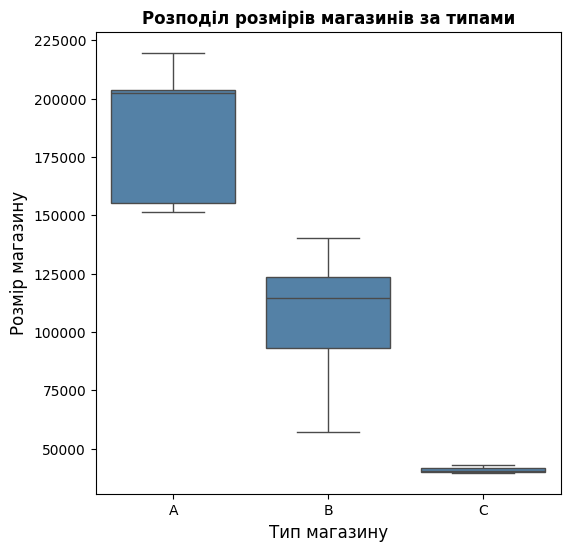

In [ ]:
print(" Графік показує розподіл розмірів магазинів за типами.")
print("1. У типу A розміри магазинів є найбільшими, що вказує на більші площі для цих магазинів.")
print("2. Типи B та C мають менший розмір, що може свідчити про їхню спеціалізацію на менших площах.")

type_size_df = df.select("Type", "Size").distinct()
type_size_pd = type_size_df.toPandas()

plt.figure(figsize=(6, 6))
sns.boxplot(x="Type", y="Size", data=type_size_pd, showfliers=False, color='steelblue')

plt.title("Розподіл розмірів магазинів за типами", fontsize=12, weight='bold')
plt.xlabel("Тип магазину", fontsize=12)
plt.ylabel("Розмір магазину", fontsize=12)

plt.show()

In [ ]:
df = df.filter(df["Weekly_Sales"] > 100)

Ця діаграма показує середній обсяг тижневих продажів для святкових і несвяткових періодів.
Вона допомагає побачити, як святкові дні впливають на рівень продажів у магазинах Walmart.


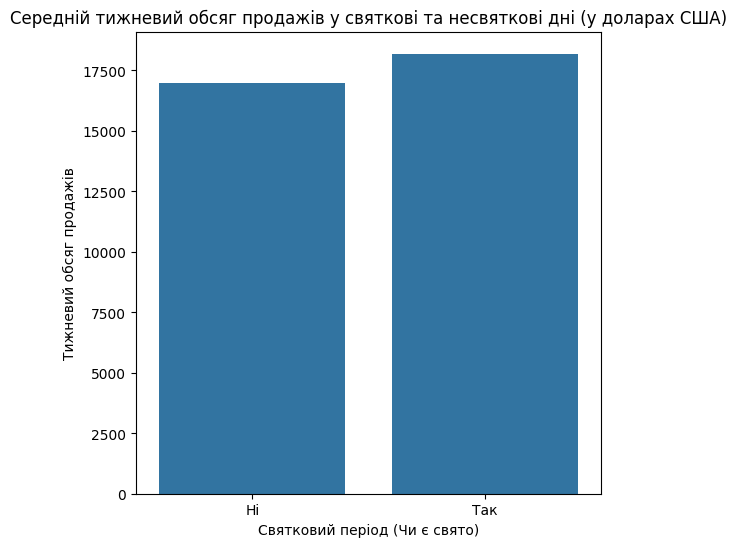


Отримані результати:
   IsHoliday  Avg_Weekly_Sales
0       True      18186.545192
1      False      16992.717672


In [ ]:
print("Ця діаграма показує середній обсяг тижневих продажів для святкових і несвяткових періодів.")
print("Вона допомагає побачити, як святкові дні впливають на рівень продажів у магазинах Walmart.")

df_pandas = df.groupBy("IsHoliday").agg({"Weekly_Sales": "avg"}).toPandas()
df_pandas.rename(columns={"avg(Weekly_Sales)": "Avg_Weekly_Sales"}, inplace=True)

plt.figure(figsize=(6, 6))
sns.barplot(x="IsHoliday", y="Avg_Weekly_Sales", data=df_pandas)

plt.title("Середній тижневий обсяг продажів у святкові та несвяткові дні (у доларах США)")
plt.xlabel("Святковий період (Чи є свято)")
plt.ylabel("Тижневий обсяг продажів")
plt.xticks([0, 1], ["Ні", "Так"])
plt.show()

print("\nОтримані результати:")
print(df_pandas)

Цей графік показує загальний обсяг продажів для кожного магазину за весь період спостереження.


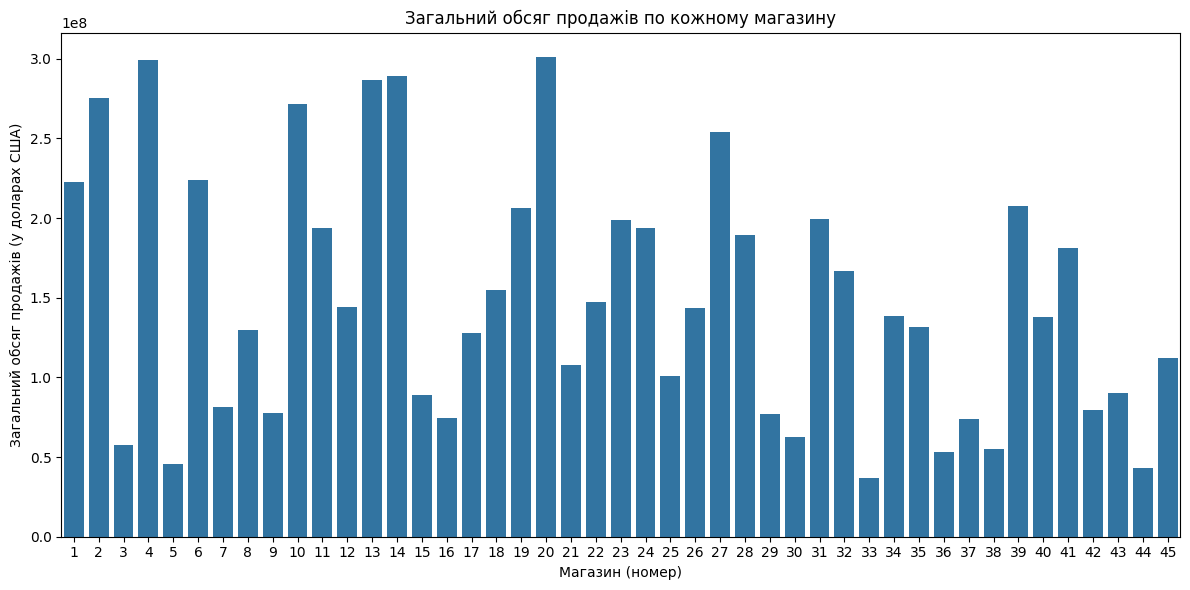


Отримані результати:
    Store   total_sales
0      28  1.892629e+08
1      26  1.434037e+08
2      27  2.538443e+08
3      12  1.442745e+08
4      22  1.470626e+08
5       1  2.223986e+08
6      13  2.865093e+08
7       6  2.237512e+08
8      16  7.423106e+07
9       3  5.757148e+07
10     20  3.013951e+08
11      5  4.546046e+07
12     19  2.066308e+08
13     15  8.911655e+07
14      9  7.777538e+07
15     17  1.277669e+08
16      4  2.995389e+08
17      8  1.299455e+08
18     23  1.987353e+08
19      7  8.157640e+07
20     10  2.716134e+08
21     25  1.010533e+08
22     24  1.940002e+08
23     29  7.712437e+07
24     21  1.081048e+08
25     11  1.939571e+08
26     14  2.889919e+08
27      2  2.753797e+08
28     18  1.551028e+08
29     31  1.996035e+08
30     34  1.382368e+08
31     44  4.322616e+07
32     40  1.378547e+08
33     41  1.813337e+08
34     43  9.051654e+07
35     37  7.415017e+07
36     35  1.315094e+08
37     39  2.074390e+08
38     45  1.123860e+08
39     38  5.50870

In [ ]:
print("Цей графік показує загальний обсяг продажів для кожного магазину за весь період спостереження.")

sales_by_store_df = df.groupBy("Store") \
                      .agg(spark_sum("Weekly_Sales").alias("total_sales"))
sales_by_store_pd = sales_by_store_df.toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x="Store", y="total_sales", data=sales_by_store_pd)
plt.xlabel("Магазин (номер)")
plt.ylabel("Загальний обсяг продажів (у доларах США)")
plt.title("Загальний обсяг продажів по кожному магазину")
plt.tight_layout()
plt.show()

print("\nОтримані результати:")
print(sales_by_store_pd)
print("Аналіз дозволяє виявити магазини з найвищими та найнижчими загальними продажами.")
print("Наприклад, магазини з особливо високими показниками можуть бути розташовані у густонаселених регіонах або мати більший розмір (тип A).")
print("Навпаки, магазини з низькими продажами можуть свідчити про менший розмір або менш активний попит.")

Цей графік показує загальний обсяг тижневих продажів по місяцях за 2011 рік.
Ми можемо побачити, як змінюється попит на продукцію протягом року.


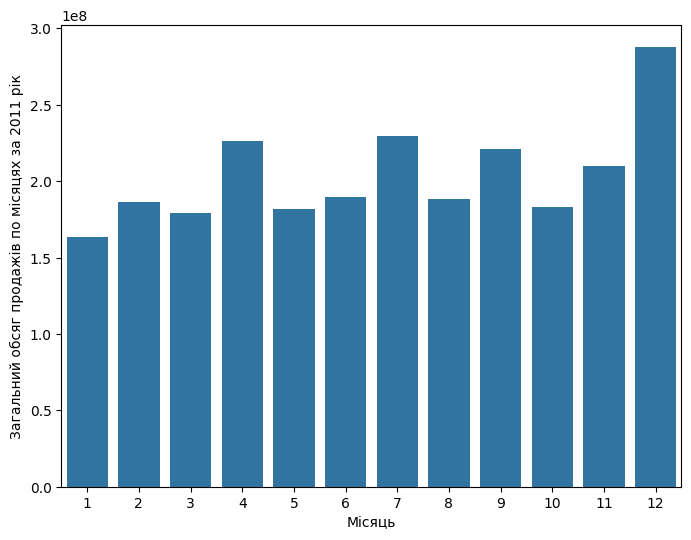


Отримані результати:
    Month   total_sales
0       1  1.636789e+08
1       2  1.863073e+08
2       3  1.793326e+08
3       4  2.264947e+08
4       5  1.816203e+08
5       6  1.897466e+08
6       7  2.298812e+08
7       8  1.885732e+08
8       9  2.208194e+08
9      10  1.832357e+08
10     11  2.101357e+08
11     12  2.880517e+08
З отриманих результатів видно, що деякі місяці мають значно вищі продажі, ніж інші.
Це свідчить про сезонність у попиті на товари, зокрема в періоди свят або сезонних акцій.


In [ ]:
print("Цей графік показує загальний обсяг тижневих продажів по місяцях за 2011 рік.")
print("Ми можемо побачити, як змінюється попит на продукцію протягом року.")

df_monthly = df.withColumn("Month", month(col("Date"))) \
               .withColumn("Year", year(col("Date")))

df_2011 = df_monthly.filter(col("Year") == 2011)

monthly_totals_2011 = df_2011.groupBy("Month") \
                             .agg(spark_sum("Weekly_Sales").alias("total_sales")) \
                             .orderBy("Month")
monthly_2011_pd = monthly_totals_2011.toPandas()

plt.figure(figsize=(8,6))
sns.barplot(x="Month", y="total_sales", data=monthly_2011_pd)
plt.xlabel("Місяць")
plt.ylabel("Загальний обсяг продажів по місяцях за 2011 рік")
plt.show()

print("\nОтримані результати:")
print(monthly_2011_pd)
print("З отриманих результатів видно, що деякі місяці мають значно вищі продажі, ніж інші.")
print("Це свідчить про сезонність у попиті на товари, зокрема в періоди свят або сезонних акцій.")

In [ ]:
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
print("Цей код виконує обробку даних для моделі лінійної регресії.")
print("Спочатку ми перетворюємо категоріальні та числові дані у відповідні формати для використання в моделі.")
print("\nПеретворення типів даних:")
print("1. Колонка 'IsHoliday' була приведена до типу integer.")
print("2. Колонки 'CPI' та 'Unemployment' були приведені до типу double.")

print("\nДалі ми індексуємо категоріальні змінні:")
print("1. Колонка 'Type' була індексована у 'TypeIndex'.")
print("2. Колонка 'IsHoliday' була індексована у 'IsHolidayIndex'.")

print("\nВибір ознак для моделі:")
print("Ознаки для моделі включають 'Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'TypeIndex', 'IsHolidayIndex'.")

print("\nПісля цього ми використовуємо VectorAssembler для створення вектора ознак.")
print("Модель лінійної регресії побудована на основі цих ознак для прогнозування 'Weekly_Sales'.")

print("\nДалі ми розділяємо дані на навчальну та тестову вибірки, навчаємо модель та здійснюємо передбачення.")
print("Це дозволяє зробити висновок, які ознаки мають найбільший вплив на прогнозовані продажі.")

# Каст до числових типів
df = df.withColumn("IsHoliday", col("IsHoliday").cast("integer"))
df = df.withColumn("CPI", col("CPI").cast("double"))
df = df.withColumn("Unemployment", col("Unemployment").cast("double"))


indexer = StringIndexer(inputCol="Type", outputCol="TypeIndex")
holiday_indexer = StringIndexer(inputCol="IsHoliday", outputCol="IsHolidayIndex")

# Вибір ознак
feature_columns = ["Store", "Dept", "Size", "Temperature", "Fuel_Price",
                   "CPI", "Unemployment", "TypeIndex", "IsHolidayIndex"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Модель лінійної регресії
lr = LinearRegression(featuresCol="features", labelCol="Weekly_Sales")


pipeline = Pipeline(stages=[indexer, holiday_indexer, assembler, lr])
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)
predictions = model.transform(test_df)

lr_model = model.stages[-1]

coeffs = lr_model.coefficients.toArray()
intercept = lr_model.intercept

coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': coeffs
})
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('AbsCoefficient', ascending=False)


print(coef_df[["Feature", "Coefficient"]])
print(f"{'Intercept':15s} : {intercept:+.2f}")

evaluator = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

print(f"Точність моделі (R²): {r2:.4f}")

Цей код виконує обробку даних для моделі лінійної регресії.
Спочатку ми перетворюємо категоріальні та числові дані у відповідні формати для використання в моделі.

Перетворення типів даних:
1. Колонка 'IsHoliday' була приведена до типу integer.
2. Колонки 'CPI' та 'Unemployment' були приведені до типу double.

Далі ми індексуємо категоріальні змінні:
1. Колонка 'Type' була індексована у 'TypeIndex'.
2. Колонка 'IsHoliday' була індексована у 'IsHolidayIndex'.

Вибір ознак для моделі:
Ознаки для моделі включають 'Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'TypeIndex', 'IsHolidayIndex'.

Після цього ми використовуємо VectorAssembler для створення вектора ознак.
Модель лінійної регресії побудована на основі цих ознак для прогнозування 'Weekly_Sales'.

Далі ми розділяємо дані на навчальну та тестову вибірки, навчаємо модель та здійснюємо передбачення.
Це дозволяє зробити висновок, які ознаки мають найбільший вплив на прогнозовані продажі.
          Feature  

In [ ]:
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Спочатку індексуємо категоріальні змінні
indexer = StringIndexer(inputCol="Type", outputCol="TypeIndex")
holiday_indexer = StringIndexer(inputCol="IsHoliday", outputCol="IsHolidayIndex")


# Створення вектору ознак
feature_columns = ["Store", "Dept", "Size", "Temperature", "Fuel_Price",
                   "CPI", "Unemployment", "TypeIndex", "IsHolidayIndex"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

df = indexer.fit(df).transform(df)
df = holiday_indexer.fit(df).transform(df)

# 2. Створення вектора ознак
df = assembler.transform(df)

# Розділення на тренувальну та тестову вибірки
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Модель Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="Weekly_Sales")
rf_model = rf.fit(train_df)  # Навчання моделі на тренувальних даних

# Прогнозування на тестових даних
predictions = rf_model.transform(test_df)

# Оцінка моделі за допомогою RegressionEvaluator (R²)
evaluator = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="r2")
r3 = evaluator.evaluate(predictions)

# Виводимо результат
print("Точність моделі (R²):", r3)

# Отримуємо важливість ознак
feature_importance = rf_model.featureImportances.toArray()

# Створюємо DataFrame з важливістю ознак
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
})

# Сортуємо ознаки за важливістю
importance_df = importance_df.sort_values('Importance', ascending=False)

# Виводимо результат
print("\nВажливість ознак для моделі Random Forest:")
print(importance_df)

Точність моделі (R²): 0.3603975410992455

Важливість ознак для моделі Random Forest:
          Feature  Importance
1            Dept    0.668187
2            Size    0.159518
7       TypeIndex    0.082634
0           Store    0.055998
5             CPI    0.018680
6    Unemployment    0.013245
3     Temperature    0.001135
4      Fuel_Price    0.000580
8  IsHolidayIndex    0.000023


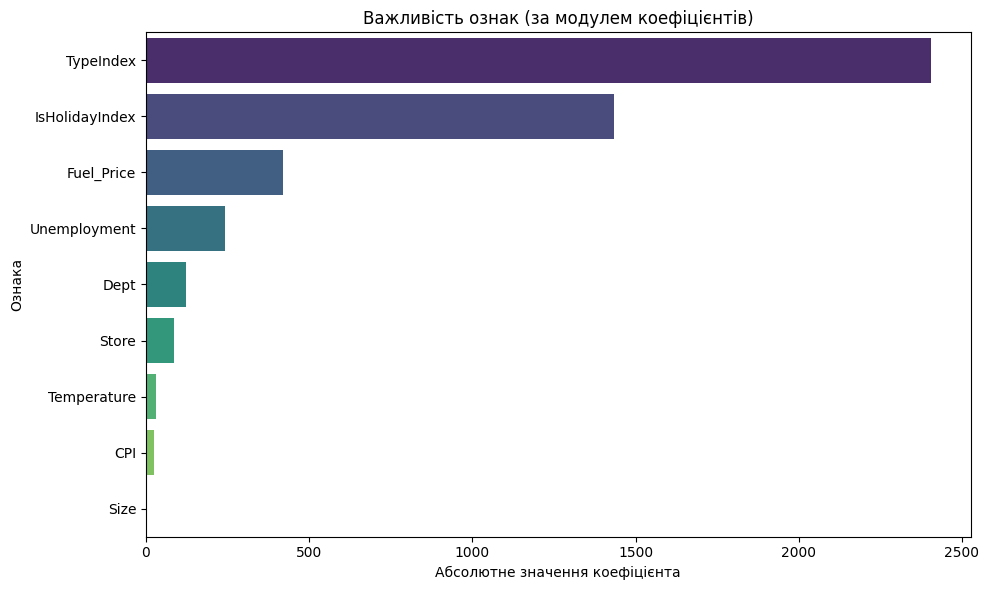


Цей графік показує важливість ознак, що використовуються в моделі лінійної регресії для прогнозування тижневих продажів.

Ми можемо побачити, які ознаки мають найбільший вплив на результат моделі.
Зокрема, найбільший вплив мають ознаки 'TypeIndex' та 'IsHolidayIndex', які мають найбільші значення позитивних коефіцієнтів.
Це означає, що тип магазину та святковий статус мають найбільший вплив на продажі.
Ознаки з малими коефіцієнтами, такі як 'Fuel_Price', 'Unemployment' та 'CPI', зменшують обсяг продажів.
'Size', наприклад, має мінімальний вплив на результати.

Результати дозволяють фокусуватися на важливих факторах для покращення прогнозування продажів та оптимізації стратегії.


In [ ]:
# Графік важливості ознак
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x="AbsCoefficient", y="Feature", hue="Feature", dodge=False, palette="viridis", legend=False)
plt.title("Важливість ознак (за модулем коефіцієнтів)")
plt.xlabel("Абсолютне значення коефіцієнта")
plt.ylabel("Ознака")
plt.tight_layout()
plt.show()

# Висновок:
print("\nЦей графік показує важливість ознак, що використовуються в моделі лінійної регресії для прогнозування тижневих продажів.")
print("\nМи можемо побачити, які ознаки мають найбільший вплив на результат моделі.")
print("Зокрема, найбільший вплив мають ознаки 'TypeIndex' та 'IsHolidayIndex', які мають найбільші значення позитивних коефіцієнтів.")
print("Це означає, що тип магазину та святковий статус мають найбільший вплив на продажі.")
print("Ознаки з малими коефіцієнтами, такі як 'Fuel_Price', 'Unemployment' та 'CPI', зменшують обсяг продажів.")
print("'Size', наприклад, має мінімальний вплив на результати.")
print("\nРезультати дозволяють фокусуватися на важливих факторах для покращення прогнозування продажів та оптимізації стратегії.")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


pandas_df = df.toPandas()

categorical_features = ['Type', 'IsHoliday']
numeric_features = ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

X = pandas_df[numeric_features + categorical_features]
y = pandas_df['Weekly_Sales']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_prep = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=42)

# Побудова моделі
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=2,
    batch_size=64,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"\nTest MAE: {test_mae:.2f}")

def get_feature_importance(model, X_sample, feature_names, num_samples=100):
    """Calculate feature importance using permutation importance"""
    baseline_score = model.evaluate(X_sample, y_test[:len(X_sample)], verbose=0)[0]
    importance_scores = []

    for i in range(len(feature_names)):
        X_permuted = X_sample.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
        permuted_score = model.evaluate(X_permuted, y_test[:len(X_sample)], verbose=0)[0]
        importance = permuted_score - baseline_score
        importance_scores.append(importance)

    return importance_scores

numeric_feature_names = numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

sample_size = min(1000, len(X_test))
X_sample = X_test[:sample_size]
importance_scores = get_feature_importance(model, X_sample, all_feature_names)

importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importance_scores
}).sort_values('Importance', ascending=False)

Epoch 1/2
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 600593920.0000 - mae: 15223.9951 - val_loss: 490760416.0000 - val_mae: 15010.9092
Epoch 2/2
3945/3945 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 487383040.0000 - mae: 14962.1982 - val_loss: 479588192.0000 - val_mae: 14635.5137
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 461596960.0000 - mae: 14522.8506

Test MAE: 14498.91


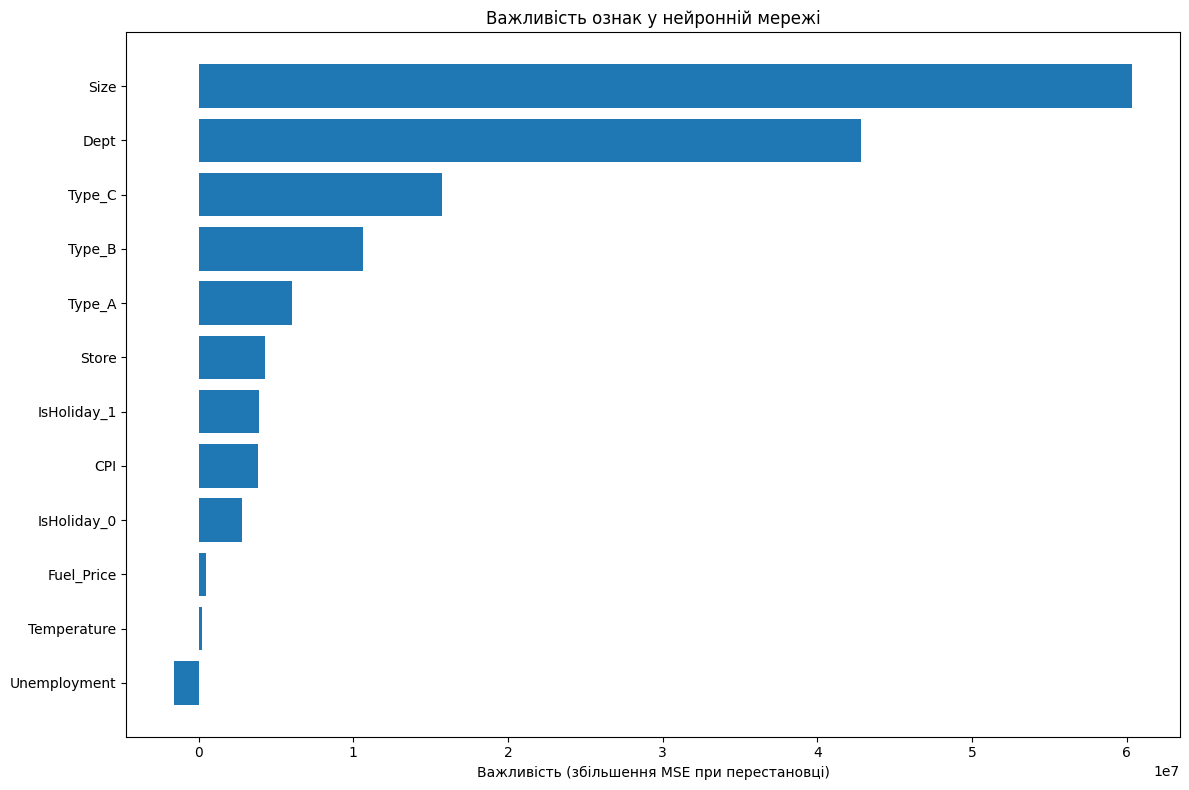


Аналіз важливості ознак:
         Feature  Importance
2           Size  60346816.0
1           Dept  42815328.0
9         Type_C  15754912.0
8         Type_B  10612128.0
7         Type_A   6051232.0
0          Store   4294048.0
11   IsHoliday_1   3893248.0
5            CPI   3836960.0
10   IsHoliday_0   2779616.0
4     Fuel_Price    459200.0
3    Temperature    212192.0
6   Unemployment  -1574496.0

Ключові висновки:
1. Найважливіші ознаки для прогнозування щотижневих продажів:
   - Size
   - Dept
   - Type_C


In [ ]:
# Побудова графіка важливості ознак
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Важливість (збільшення MSE при перестановці)')
plt.title('Важливість ознак у нейронній мережі')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Виведення результатів
print("\nАналіз важливості ознак:")
print(importance_df)
print("\nКлючові висновки:")
print("1. Найважливіші ознаки для прогнозування щотижневих продажів:")
print("   -", importance_df.iloc[0]['Feature'])
print("   -", importance_df.iloc[1]['Feature'])
print("   -", importance_df.iloc[2]['Feature'])